In [1]:
import holopy as hp
from holopy.scattering import Scatterer, Sphere, calc_holo
from holopy.scattering.scatterer import Indicators
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import json
from pylorenzmie.theory import coordinates, LMHologram
from pylorenzmie.analysis.Feature import Feature
from holopy.scattering.theory import DDA
import time

/home/lauren/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/lauren/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
INFO:pylorenzmie.fitting:No module named 'pylorenzmie.fitting.cython.cminimizers'
INFO:pylorenzmie.theory:Could not import CUDA GPU pipeline. No module named 'cupy'


In [2]:
font = {'size'   : 16}

matplotlib.rc('font', **font)

In [3]:
#Instrument parameters:
wv = 0.447
mag = 0.120
n_m = 1.34 #assume water

In [4]:
def bound_spheres(a_p, n_p, a_1, n_1, z_p, spacing):
    #generates holograms with a single coating and double coating 
    detector = hp.detector_grid(200, mag)
    center = (mag*100, mag*100, z_p)
    sphere = Sphere(r = a_p, center = (0, 0, 0))

    dda = DDA(max_dpl_size = spacing)
    space_btwn = dda.required_spacing(wv, n_m, n_p)
    print(space_btwn)

    r_sum1 = a_1 + a_p
    
    indicators_sphere = Indicators([sphere.contains], 
                                   [[-r_sum1, r_sum1], [-r_sum1, r_sum1], [-r_sum1, r_sum1]])
    
    sphere_scatterer = Scatterer(indicators_sphere,
                     n_p, center)
    
    start_time = time.time()
    holo = np.squeeze(calc_holo(detector, sphere_scatterer, medium_index=n_m, illum_wavelen=wv, illum_polarization=(1, 0)
                                , theory = dda
                               ).data)
    compute_time = (time.time() - start_time)
    print(compute_time)

    binding1 = Sphere(r = r_sum1, center = (0, 0, 0))
    
    def coating1(point):
        return(np.logical_and(binding1.contains(point),
           np.logical_not(sphere.contains(point))))

    indicators_single = Indicators([sphere.contains, coating1],
                        [[-r_sum1, r_sum1], [-r_sum1, r_sum1], [-r_sum1, r_sum1]])
    

    single_scatterer = Scatterer(indicators_single,
                     (n_p, n_1), center)
    
    single_holo = np.squeeze(calc_holo(detector, single_scatterer, medium_index=n_m, illum_wavelen=wv, illum_polarization=(1, 0)
                                      , theory = dda
                                      ).data)
    
    return holo, single_holo, space_btwn, compute_time

In [4]:
a_p = 0.5 #um
n_p = 1.6 #polystyrene
z_p = 50

a_1 = 0.01
n_1s = [1.45, 1.7]
spacings = [0.01, 0.02, None]

samples = {'z_p': z_p, 'a_p': a_p, 'n_p': n_p, 'a_1': a_1, 'n_1': [], 'spacing': [], 'data0': [], 'data1': [], 'compute_time' : []}

for i in range(len(n_1s)):
    for j in range(len(spacings)):
        n_1 = n_1s[i]
        spacing = spacings[j]
        data0, data1, space_btwn, compute_time = bound_spheres(a_p, n_p, a_1, n_1, z_p, spacing)
        plt.imshow(data0)
        plt.show()
        plt.imshow(data1)
        plt.show()
        samples['n_1'].append(n_1)
        samples['spacing'].append(space_btwn)
        samples['data0'].append(data0.tolist())
        samples['data1'].append(data1.tolist())
        samples['compute_time'].append(compute_time)
    
    print(i, ' completed', end='\r')

NameError: name 'bound_spheres' is not defined

In [6]:
with open('./data/singlecoat_test_spacing_DDA.json', 'r') as f:
    samples = json.load(f)

Set up pylorenzmie fitting pipeline

In [9]:
feature = Feature(model=LMHologram())
shape = [200, 200]
feature.model.coordinates = coordinates(shape, dtype=np.float32)
ins = feature.model.instrument
ins.wavelength = wv
ins.magnification = mag
ins.n_m = n_m

p = feature.model.particle
p.r_p = [shape[0]//2, shape[1]//2, z_p/mag]

feature.optimizer.mask.settings['distribution'] = 'fast'
feature.optimizer.mask.settings['percentpix'] = .1
feature.model.coordinates = coordinates(shape, dtype=np.float32)
#feature.model.double_precision = False

In [10]:
#parameters that pylorenzmie will fit to
samples['a_p*0'] = [] 
samples ['n_p*0'] = []
samples['a_p*1'] = [] 
samples ['n_p*1'] = []

for n in range(len(samples['data0'])):
    #plt.imshow(np.array(samples['data0'][n]))
    #plt.show()
    p = feature.model.particle
    
    #fit 1:  core sphere
    p.r_p = [shape[0]//2, shape[1]//2, z_p/mag]
    p.a_p = samples['a_p']
    p.n_p = samples['n_p']
    feature.data = np.array(samples['data0'][n])
    result = feature.optimize(method='lm', verbose=False)
    print(result)
    a_fit = feature.model.particle.a_p
    n_fit = feature.model.particle.n_p
    
    samples['a_p*0'].append(a_fit)
    samples['n_p*0'].append(n_fit)
    
    #fit 2:  single coating
    p.r_p = [shape[0]//2, shape[1]//2, z_p/mag]
    p.a_p = samples['a_p']
    p.n_p = samples['n_p']
    feature.data = np.array(samples['data1'][n])
    result = feature.optimize(method='lm', verbose=False)
    print(result)
    a_fit = feature.model.particle.a_p
    n_fit = feature.model.particle.n_p
    
    samples['a_p*1'].append(a_fit)
    samples['n_p*1'].append(n_fit)

FIT REPORT
---------------------------------------------
method: lm
success: True
message: Both `ftol` and `xtol` termination conditions are satisfied.
redchi: 0.0006156878533978431
nfev: 19
x_p: 99.95798 (init: 100.00000)
y_p: 99.95999 (init: 100.00000)
z_p: 416.45108 (init: 416.66667)
a_p: 0.49959 (init: 0.50000)
n_p: 1.59481 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.12000 (init: 0.12000) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: lm
success: True
message: Both `ftol` and `xtol` termination conditions are satisfied.
redchi: 0.0006242089297825365
nfev: 19
x_p: 100.04057 (init: 100.00000)
y_p: 100.04219 (init: 100.00000)
z_p: 416.36483 (init: 416.66667)
a_p: 0.50384 (init: 0.50000)
n_p: 1.59455 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 

In [12]:
savesamples = samples.copy()
del savesamples['data0']
del savesamples['data1'] #omit data column to save space

with open('./data/singlecoat_test_spacing.json', 'w') as f:
    json.dump(savesamples, f)

# df = pd.DataFrame(savesamples)
#print(df)

n_1 = df.n_1

delta_a = 1e3*(df['a_p*1'] - df['a_p*0'])
delta_n = 1e3*(df['n_p*1'] - df['n_p*0'])

#linear regression
#m, b = np.polyfit(a_1, delta_a, 1)
#fit_delta_a = [x*m + b for x in a_1]

#m_str = '%.2f'%m
#b_str = '%.2f'%b

fig, ax = plt.subplots()
ax.scatter(n_1, delta_a, c='b')
ax.scatter(n_1, delta_n, c='r')
#ax.plot(n_1, fit_delta_a, c='r')
#ax.set_xlabel(r'Coating length $a_1$ [nm]')
#ax.set_ylabel(r'Difference in fits $\Delta a_p^*$ [nm]')
#ax.text(6, 24, r'$\Delta a_p^* = {} a_1 + {}$'.format(m_str, b_str))
plt.show()



#fig.savefig('')

NameError: name 'delta_n' is not defined

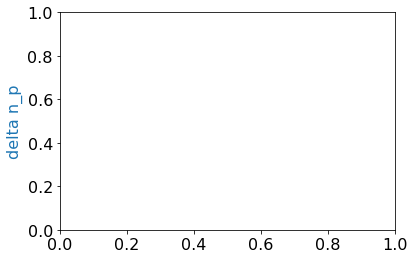

In [15]:
fig, ax2 = plt.subplots()

'''
color = 'tab:red'
ax1.set_xlabel('n_1')
ax1.set_ylabel('delta a_p', color=color)
ax1.scatter(n_1, delta_a, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
'''

color = 'tab:blue'
ax2.set_ylabel('delta n_p', color=color)  # we already handled the x-label with ax1
ax2.scatter(n_1, delta_n, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#fig.savefig()